<a href="https://colab.research.google.com/github/RodolfoFigueroa/madi2022-1/blob/main/Unidad_4/01_Ordenamiento_topologico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import networkx as nx
from queue import deque

En esta libreta, veremos un recordatorio de ordenamiento topológico, y cómo puede aplicarse para resolver distintos problemas.

# Definición

Copiando lo que habíamos escrito en la libreta `6_NetworkX_para_graficas_planares_y_dirigidas` (Unidad 1), tenemos que un ordenamiento topológico de los vértices de una gráfica dirigida cumple que, si existe una arista del vértice $u$ al vértice $v$, entonces $u$ viene antes de $v$ en el ordenamiento.

Por ejemplo, tomando la siguiente gráfica:

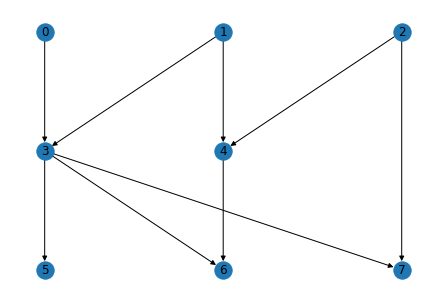

In [60]:
g = nx.DiGraph()
g.add_nodes_from([0,1,2,3,4,5,6,7])
g.add_edges_from([(0,3), (1,3), (1,4), (2,4), (2,7), (3,5), (3,6), (3,7), (4,6)])
pos = {i: (i%3, 3-i//3*3) for i in g.nodes}
pos[5], pos[6], pos[7] = [0,-3], [1,-3], [2,-3]
nx.draw(g, with_labels=True, pos=pos)

Algunos ordenamientos posibles son:

* 0, 1, 2, 3, 4, 5, 6, 7
* 2, 0, 1, 4, 3, 5, 6, 7
* 0, 1, 2, 4, 3, 7, 6, 5

Una manera sencilla de comprobar si un ordenamiento es válido es colocar a todos los vértices en una fila, siguiendo el ordenamiento de izquierda a derecha. Si todas las aristas apuntan hacia la derecha, entonces es válido.

# Algoritmos

## Post-order

En la libreta previamente mencionada, probamos que una manera de generar un ordenamiento topológico es la de recorrer la gráfica en reverse postorder, lo cual se ve reflejado en la siguiente función:

In [61]:
def _order_handler(g, v, kind, visited=None, out=None): 
    visited[v] = True
    if kind == 'preorder':
        out.append(v)
    for u in g.adj[v]:
        if not visited[u]:
            _order_handler(g, u, kind, visited, out) # recursion
    if kind != 'preorder': # postorder or reverse_postorder
        out.append(v)


def order(g, kind):
    visited = [False] * len(g.nodes)
    out = []
    for n in g.nodes:
        if not visited[n]:
            _order_handler(g, n, kind, visited, out)
            
    if kind == 'reverse_postorder':
        return out[::-1]
    else:
        return out

Aplicándola a nuestra gráfica anterior:

In [62]:
res = order(g, 'reverse_postorder')
res

[2, 1, 4, 0, 3, 7, 6, 5]

Podemos comprobar a ojo que es un ordenamiento correcto:

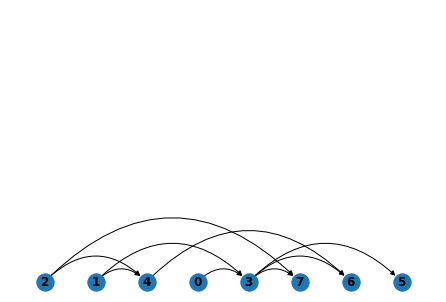

In [63]:
def pos_order(order):
    pos = {}
    for i, p in enumerate(order):
        pos[p] = (i,0)
    return pos

pos = pos_order(res)
nx.draw(g, pos=pos, connectionstyle="arc3,rad=-0.5", with_labels=True, font_weight='bold')

Claramente, todas las aristas apuntan en la misma dirección.

## Kahn

Otra manera de generar un ordenamiento es utilizando el algoritmo de Kahn. Este puede expresarse en pseudocódigo como:

* $S$: Conjunto de vértices sin ninguna arista entrante. Al inicio es no-vacío (de otra manera la gráfica no tiene un ordenamiento topológico válido).
* $L$: Lista que contendrá los vértices en orden topológico.
1. Mientras $S$ no es vacío:
    1. Tomamos un vértice $n$ de $S$.
    2. Añadimos $n$ a $L$.
    3. Para cada vértice $m$ con arista $e$ de $n$ a $m$:
        1. Removemos a $e$ de la gráfica
        2. Si $m$ no tiene más aristas entrantes, lo insertamos en $S$.

Si al final de la ejecución, la gráfica sigue teniendo aristas, significa que tenía un ciclo, y por lo tanto no tiene un ordenamiento. De otra manera, $L$ será un ordenamiento válido.

Expresado en código, el algoritmo es:

In [33]:
list(g.neighbors(2)) 

[4, 7]

In [52]:
def kahn_order(g):
    g = g.copy()
    S = deque()
    L = []
    for n in g.nodes:
        if g.in_degree(n) == 0:
            print('n', n)
            S.append(n)
            
    while S:
        n = S.pop()
        print('pop', n)
        L.append(n)
        neighbors = list(g.neighbors(n)) 
        for m in neighbors:
            g.remove_edge(n, m)
            if g.in_degree(m) == 0:
                S.append(m)
    
    assert len(g.edges) == 0, "La gráfica tiene un ciclo."
    
    return L

Aplicándolo a nuestra gráfica:

In [53]:
res = kahn_order(g)
res

n 0
n 1
n 2
pop 2
pop 1
pop 4
pop 0
pop 3
pop 7
pop 6
pop 5


[2, 1, 4, 0, 3, 7, 6, 5]

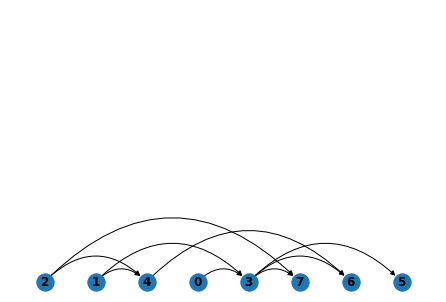

In [72]:
pos = pos_order(res)
nx.draw(g, pos=pos, connectionstyle="arc3,rad=-0.5", with_labels=True, font_weight='bold')

Veamos qué pasa con una gráfica que tiene ciclos:

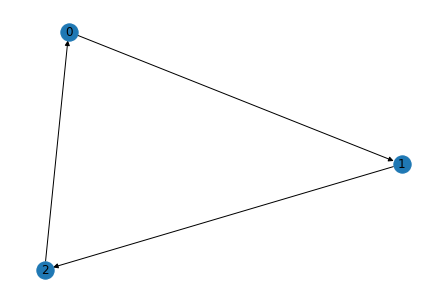

In [70]:
g_ciclo = nx.DiGraph()
g_ciclo.add_edges_from([(0, 1), (1,2), (2,0)])
nx.draw(g_ciclo, with_labels=True)

In [71]:
kahn_order(g_ciclo)

AssertionError: La gráfica tiene un ciclo.

Graficando:

# Camino más corto

Una aplicación del ordenamiento topológico es encontrar el camino más corto entre un nodo $s$ y todos los demás en una gráfica con pesos. Para hacerlo, seguimos el siguiente algoritmo:

* $d$: Lista con las distancias mínimas de cada vértice a $s$. Al inicio, $d[v]=\infty$ para toda $v\neq s$, y $d[s] = 0$.
* $p$: $p[u]$ será el predecesor de $u$ en el camino más corto de $v$ a $u$. Al inicio todas sus entradas son vacías.

1. Para cada $u$ en el ordenamiento topológico de la gráfica, empezando de $s$:
    1. Para cada vértice $v$ tal que existe una arista $(u,v)$:
        1. $w\leftarrow \text{peso}(u,v)$
        2. Si $d[v] > d[u] + w$:
            1. $d[v] \leftarrow d[u] + w$
            2. $p[v] \leftarrow u$
        
Este algoritmo solo funciona si revisamos los vértices $u$ en orden topológico, ya que de esta manera vamos actualizando las distancias de manera ordenada.

Por ejemplo, para la siguiente gráfica:

{(0, 1): Text(0.654508476093664, 0.47552828417802706, '1'),
 (0, 2): Text(0.09549147175227024, 0.2938926307527015, '5'),
 (1, 2): Text(-0.25000005215406573, 0.7694209149307285, '3'),
 (1, 3): Text(-0.25000002235174246, 0.18163562362300228, '2'),
 (1, 4): Text(0.3090170266931363, 2.980232327587373e-08, '10'),
 (3, 4): Text(-0.24999994784593424, -0.7694209149307285, '2')}

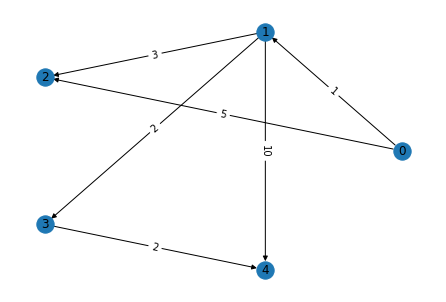

In [74]:
g = nx.DiGraph()
g.add_nodes_from(range(5))
g.add_edges_from([
    (0, 1, {'weight': 1}), 
    (1, 2, {'weight': 3}), 
    (3, 4, {'weight': 2}), 
    (1, 3, {'weight': 2}), 
    (0, 2, {'weight': 5}), 
    (1, 4, {'weight': 10})
])
pos = nx.circular_layout(g)
nx.draw(g, pos=pos, with_labels=True)
labels = nx.get_edge_attributes(g, 'weight')
nx.draw_networkx_edge_labels(g, pos, edge_labels=labels)

In [77]:
def shortest_paths(g, s):
    d = [float('inf')] * len(g.nodes)
    d[s] = 0
    p = [None] * len(g.nodes)
    
    order = kahn_order(g)
    idx = order.index(s)
    for u in order[idx:]:
        for v in g.neighbors(u):
            w = g.edges[(u,v)]['weight']
            if d[v] > d[u] + w:
                d[v] = d[u] + w
                p[v] = u
    return p, d
                
p, d = shortest_paths(g, 0)
print(f"Predecesores: {p}")
print(f"Distancias: {d}")

Predecesores: [None, 0, 1, 1, 3]
Distancias: [0, 1, 4, 3, 5]


# Ejercicios

Para los siguientes problemas, solo puedes usar funciones básicas de `networkx` (`nodes`, `edges`, `neighbors`, `degree`, etc.) No puedes utilizar nada relacionado a ordenamientos topológicos/DFS/BFS.

## Ejercicio 1

Escribe una función que genere todos los ordenamientos topológicos posibles de una gráfica. Compara tu resultado con lo obtenido con `nx.all_topological_sorts`.

*Aquí va la explicación de tu algoritmo*

In [1]:
import networkx as nx
from collections import deque

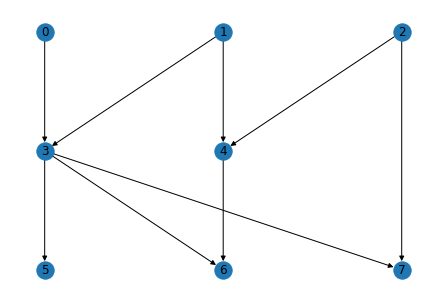

In [2]:
g = nx.DiGraph()
g.add_nodes_from([0,1,2,3,4,5,6,7])
g.add_edges_from([(0,3), (1,3), (1,4), (2,4), (2,7), (3,5), (3,6), (3,7), (4,6)])
pos = {i: (i%3, 3-i//3*3) for i in g.nodes}
pos[5], pos[6], pos[7] = [0,-3], [1,-3], [2,-3]
nx.draw(g, with_labels=True, pos=pos)

Algunos ordenamientos posibles son:

* 0, 1, 2, 3, 4, 5, 6, 7

* 2, 0, 1, 4, 3, 5, 6, 7

* 0, 1, 2, 4, 3, 7, 6, 5

* 3,0,1,2,4,5,6,7,8 (no valido

In [6]:
g.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7))

In [13]:
def order(g, v, kind, visited=None, out=None): 
    visited[v] = True
    if kind == 'preorder':
        out.append(v)
    for u in g.adj[v]:
        if not visited[u]:
            order(g, u, kind, visited, out) # recursion
    #print('v', v)
    if kind != 'preorder': # postorder or reverse_postorder
        out.append(v)


def order_handler(g, kind):
    visited = [False] * len(g.nodes)
    out = []
    for n in g.nodes:
        if not visited[n]:
            order(g, n, kind, visited, out)
            
    if kind == 'reverse_postorder':
        return out[::-1]
    else:
        return out

In [12]:
order_handler(g, 'postorder')

v 5
v 6
v 7
v 3
v 0
v 4
v 1
v 2


[5, 6, 7, 3, 0, 4, 1, 2]

In [14]:
print(f"""Preorder: {order_handler(g, 'preorder')}
Postorder: {order_handler(g, 'postorder')}
Reverse postorder: {order_handler(g, 'reverse_postorder')}""")

Preorder: [0, 3, 5, 6, 7, 1, 4, 2]
Postorder: [5, 6, 7, 3, 0, 4, 1, 2]
Reverse postorder: [2, 1, 4, 0, 3, 7, 6, 5]


In [15]:
def pos_order(order):
    pos = {}
    for i, p in enumerate(order):
        pos[p] = (i,0)
    return pos

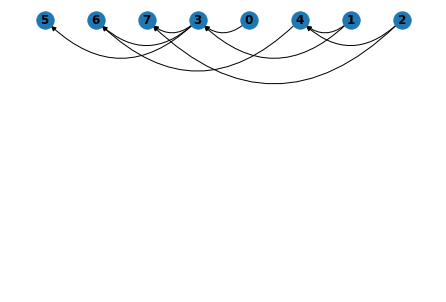

In [16]:
pos = pos_order([5, 6, 7, 3, 0, 4, 1, 2])
nx.draw(g, pos=pos, connectionstyle="arc3,rad=-0.5", with_labels=True, font_weight='bold')

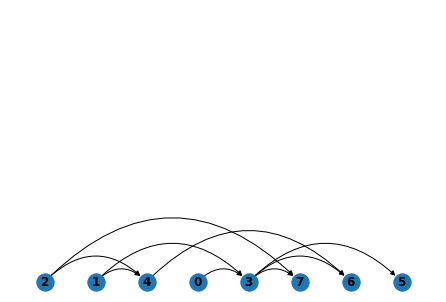

In [17]:
pos = pos_order([2, 1, 4, 0, 3, 7, 6, 5])
nx.draw(g, pos=pos, connectionstyle="arc3,rad=-0.5", with_labels=True, font_weight='bold')

In [37]:
contador = 0
for orden_topologico in nx.all_topological_sorts(g):
    print(orden_topologico)
    contador += 1
print(contador)

[2, 1, 4, 0, 3, 7, 6, 5]
[2, 1, 4, 0, 3, 7, 5, 6]
[2, 1, 4, 0, 3, 6, 5, 7]
[2, 1, 4, 0, 3, 6, 7, 5]
[2, 1, 4, 0, 3, 5, 7, 6]
[2, 1, 4, 0, 3, 5, 6, 7]
[2, 1, 0, 3, 7, 5, 4, 6]
[2, 1, 0, 3, 7, 4, 6, 5]
[2, 1, 0, 3, 7, 4, 5, 6]
[2, 1, 0, 3, 5, 4, 6, 7]
[2, 1, 0, 3, 5, 4, 7, 6]
[2, 1, 0, 3, 5, 7, 4, 6]
[2, 1, 0, 3, 4, 6, 7, 5]
[2, 1, 0, 3, 4, 6, 5, 7]
[2, 1, 0, 3, 4, 7, 5, 6]
[2, 1, 0, 3, 4, 7, 6, 5]
[2, 1, 0, 3, 4, 5, 6, 7]
[2, 1, 0, 3, 4, 5, 7, 6]
[2, 1, 0, 4, 3, 7, 6, 5]
[2, 1, 0, 4, 3, 7, 5, 6]
[2, 1, 0, 4, 3, 6, 5, 7]
[2, 1, 0, 4, 3, 6, 7, 5]
[2, 1, 0, 4, 3, 5, 7, 6]
[2, 1, 0, 4, 3, 5, 6, 7]
[2, 0, 1, 4, 3, 7, 6, 5]
[2, 0, 1, 4, 3, 7, 5, 6]
[2, 0, 1, 4, 3, 6, 5, 7]
[2, 0, 1, 4, 3, 6, 7, 5]
[2, 0, 1, 4, 3, 5, 7, 6]
[2, 0, 1, 4, 3, 5, 6, 7]
[2, 0, 1, 3, 7, 5, 4, 6]
[2, 0, 1, 3, 7, 4, 6, 5]
[2, 0, 1, 3, 7, 4, 5, 6]
[2, 0, 1, 3, 5, 4, 6, 7]
[2, 0, 1, 3, 5, 4, 7, 6]
[2, 0, 1, 3, 5, 7, 4, 6]
[2, 0, 1, 3, 4, 6, 7, 5]
[2, 0, 1, 3, 4, 6, 5, 7]
[2, 0, 1, 3, 4, 7, 5, 6]
[2, 0, 1, 3, 4, 7, 6, 5]


Vemos primeramente que nuestros algoritmos se basa en la lista inicial de vertices con la que empiza nuestro algoritmos, la idea es ir cambiando esta lista para poder ir cambiando el orden por el cual analiza el primer nodo, por lo tanto primero buscaremos las combinaciones posibles

In [4]:
def find_all_topogical_orders(graph, path, discovered, N):
    g = graph.copy()
    for v in g.nodes:

        if graph.in_degree(v) == 0 and not discovered[v]:

            neighbors = list(g.neighbors(v))
            for u in neighbors:
                g.remove_edge(v, u)

            path.append(v)
            discovered[v] = True
            find_all_topogical_orders(g, path, discovered, N)

            neighbors = list(graph.neighbors(v))
            for u in neighbors:
                g.add_edge(v, u)

            path.pop()
            discovered[v] = False
    
    if len(path) == N:
        print(path)
        
def printAllTopologicalOrders(graph):
 
    N = len(graph.nodes)
 
    # lista para rastrear los vertices descubiertos
    discovered = [False] * N
 
    # Almacena los ordenes topologicos encontrados
    path = []

    find_all_topogical_orders(graph, path, discovered, N)

In [5]:
printAllTopologicalOrders(g)

[0, 1, 2, 3, 4, 5, 6, 7]
[0, 1, 2, 3, 4, 5, 7, 6]
[0, 1, 2, 3, 4, 6, 5, 7]
[0, 1, 2, 3, 4, 6, 7, 5]
[0, 1, 2, 3, 4, 7, 5, 6]
[0, 1, 2, 3, 4, 7, 6, 5]
[0, 1, 2, 3, 5, 4, 6, 7]
[0, 1, 2, 3, 5, 4, 7, 6]
[0, 1, 2, 3, 5, 7, 4, 6]
[0, 1, 2, 3, 7, 4, 5, 6]
[0, 1, 2, 3, 7, 4, 6, 5]
[0, 1, 2, 3, 7, 5, 4, 6]
[0, 1, 2, 4, 3, 5, 6, 7]
[0, 1, 2, 4, 3, 5, 7, 6]
[0, 1, 2, 4, 3, 6, 5, 7]
[0, 1, 2, 4, 3, 6, 7, 5]
[0, 1, 2, 4, 3, 7, 5, 6]
[0, 1, 2, 4, 3, 7, 6, 5]
[0, 1, 3, 2, 4, 5, 6, 7]
[0, 1, 3, 2, 4, 5, 7, 6]
[0, 1, 3, 2, 4, 6, 5, 7]
[0, 1, 3, 2, 4, 6, 7, 5]
[0, 1, 3, 2, 4, 7, 5, 6]
[0, 1, 3, 2, 4, 7, 6, 5]
[0, 1, 3, 2, 5, 4, 6, 7]
[0, 1, 3, 2, 5, 4, 7, 6]
[0, 1, 3, 2, 5, 7, 4, 6]
[0, 1, 3, 2, 7, 4, 5, 6]
[0, 1, 3, 2, 7, 4, 6, 5]
[0, 1, 3, 2, 7, 5, 4, 6]
[0, 1, 3, 5, 2, 4, 6, 7]
[0, 1, 3, 5, 2, 4, 7, 6]
[0, 1, 3, 5, 2, 7, 4, 6]
[0, 2, 1, 3, 4, 5, 6, 7]
[0, 2, 1, 3, 4, 5, 7, 6]
[0, 2, 1, 3, 4, 6, 5, 7]
[0, 2, 1, 3, 4, 6, 7, 5]
[0, 2, 1, 3, 4, 7, 5, 6]
[0, 2, 1, 3, 4, 7, 6, 5]
[0, 2, 1, 3, 5, 4, 6, 7]


## Ejercicio 2

Encontraste una página del diccionario de una civilización perdida. Los habitantes utilizaban el alfabeto para escribir, pero no necesariamente en el mismo orden; por ejemplo, `b` podía venir antes de `a`. 

Basándote en el hecho de que las palabras del diccionario están ordenadas lexicográficamente, y asumiendo que solo utilizaban las letras provistas, determina el orden del alfabeto.

Como ejemplo, tomamos la lista ordenada `L=["zxx","xxx","xxy"]`. Vemos que la primera palabra empieza con `z`, mientras que las otras dos empiezan con `x`. Por lo tanto, la primera letra del alfabeto es `z`. Por otro lado, las últimas dos palabras empiezan con `xx`, pero la segunda tiene una `x`, y la tercera una `y`. Por lo tanto, `x` viene antes de `y` en el alfabeto.

De esta manera, concluimos que el alfabeto es `zxy`.

*Hint:* Si representas las letras como vértices de una gráfica, de modo que una arista entre `X` y `Y` indica que `X` viene antes que `Y`, lo único que tienes que hacer es encontrar un ordenamiento topológico. Piensa entonces cómo traducir las palabras que te dan a dicha gráfica.

**Descripción del algoritmo**

Dado que la lista que nos mencionan son listas ordenadas según su abecedario, entonces nuestro algoritmo consistite en construir un grafo que tenga un orden topologico, es decir, la primera letra de la primera palabra debe ser el el primer nodo y debe ir antes que las demás dado que nuestra lista esta ordenada por su orden lexicográfico, a partir de este iremos iterando las demas palabras con su primera y verificar que para cada letra diferente unirla con una arista con dirección hacia la letra encontrada. Depues seguirnos con la se segunda letras de las palabras, sabiendo que la primera palabra es la más ordenada entonces la segunda letra de la primera palabra seguira conservando que es la menor de las demas, seguimos el mismo procedimiento hasta acabar todas las letras y el arbol generado nos dara la información suficiente de su abecedario.

In [ ]:

g = nx.DiGraph()
g.add_nodes_from([0,1,2,3,4,5,6,7])
g.add_edges_from([(0,3), (1,3), (1,4), (2,4), (2,7), (3,5), (3,6), (3,7), (4,6)])
pos = {i: (i%3, 3-i//3*3) for i in g.nodes}
pos[5], pos[6], pos[7] = [0,-3], [1,-3], [2,-3]
nx.draw(g, with_labels=True, pos=pos)

In [3]:
L = ["zxy"]
L[0][0]

'z'

In [10]:
def pos_order(order):
    pos = {}
    for i, p in enumerate(order):
        pos[p] = (i,0)
    return pos

In [66]:
import networkx as nx
from queue import deque


def kahn_order(g):
    g = g.copy()
    S = deque()
    L = []
    for n in g.nodes:
        if g.in_degree(n) == 0:
            print('n', n)
            S.append(n)
            
    while S:
        n = S.pop()
        print('pop', n)
        L.append(n)
        neighbors = list(g.neighbors(n)) 
        for m in neighbors:
            g.remove_edge(n, m)
            if g.in_degree(m) == 0:
                S.append(m)
    
    assert len(g.edges) == 0, "La gráfica tiene un ciclo."
    
    return L

def dictionary_sort(L):
    L = L.copy()
    g = nx.DiGraph()
    i = 0
    while i < len(L[0]):
        letter = L[0][i]
        g.add_node(letter)
        for word in L:
            if i >= len(word):
                continue
            
            if word[i] != letter and word[i] not in g.nodes:
                g.add_edge(letter, word[i])
        i += 1
    nx.draw(g, with_labels=True)
    print(g.nodes)
    return (g, g.nodes)

['z', 'v', 'x', 'y', 'w']


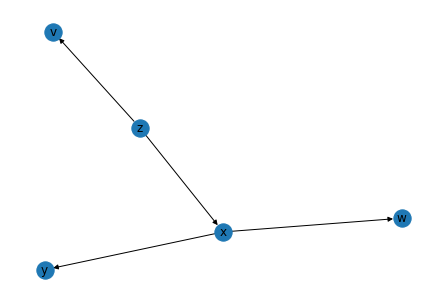

In [67]:
L = ["zxy", "zxw","vx","vyy","xwyy"]
g, abc = dictionary_sort(L)

In [63]:
'q' in g.nodes

False

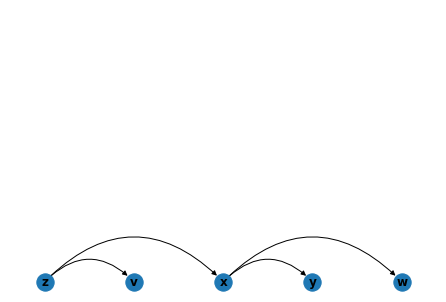

In [68]:
pos = pos_order(abc)
nx.draw(g, pos=pos, connectionstyle="arc3,rad=-0.5", with_labels=True, font_weight='bold')

['x', 'y', 'z', 'w']


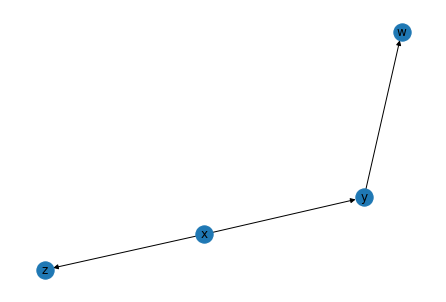

In [69]:
L = ["xyy","yxzw","yxzy","zyx","zyw"]
g, abc = dictionary_sort(L)

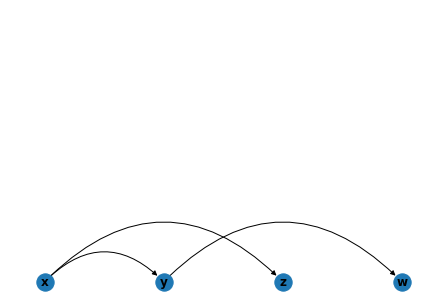

In [70]:
pos = pos_order(abc)
nx.draw(g, pos=pos, connectionstyle="arc3,rad=-0.5", with_labels=True, font_weight='bold')

Prueba tu código con la siguiente celda:

In [18]:
L = ["zxy", "zxw","vx","vyy","xwyy"]
res = dictionary_sort(L)
print(f"Ordenamiento esperado: [z, v, x, y, w]. Obtenido: {res}")

L = ["xyy","yxzw","yxzy","zyx","zyw"]
res = dictionary_sort(L)
print(f"Ordenamiento esperado: [x, w, y, z]. Obtenido: {res}")

Ordenamiento esperado: [z, v, x, y, w]. Obtenido: None
Ordenamiento esperado: [x, w, y, z]. Obtenido: None


In [104]:
#Question: Given a sorted dictionary (array of words) of an alien language, find order of characters in the language.

'''
REFERENCE:
http://www.elvisyu.com/alien-language-find-order-of-characters/#more-884
ALGORITHM:
Do following for every pair of adjacent words in given sorted array.
a) Let the current pair of words be word1 and word2. One by one compare characters of both words and find the first mismatching characters.
b) Create an edge in g from mismatching character of word1 to that of word2.
'''


def BuildAdjacencyList(a):
	graph = {}
	#create nodes
	for word in a:
		for c in word:
			if c not in graph.keys():
				graph[c] = []
	#create edges
	size = len(graph)
	for i in range(0,size):
		w1 = a[i][0]
		if (i+1 < size):
			w2 = a[i+1][0]
		else:
			w2 = ""
		if (w1 != w2 and len(w2)> 0):
			graph[w1].append(w2)
	#for key in graph:
	#	print(key,graph[key])
	return graph


#Kahn’s algorithm
#https://algocoding.wordpress.com/2015/04/05/topological-sorting-python/
def TopologicalSort(graph):
    TopologicalSortedList = []  #result
    ZeroInDegreeVertexList = [] #node with 0 in-degree/inbound neighbours
    inDegree = { u : 0 for u in graph } #inDegree/inbound neighbours

    #Step 1: Iterate graph and build in-degree for each node
    for u in graph:
        for v in graph[u]:
            inDegree[v] += 1

    #Step 2: Find node(s) with 0 in-degree
    for k in inDegree:
        #print("##########", k,inDegree[k])
        if (inDegree[k] == 0):
            ZeroInDegreeVertexList.append(k)           

    #Step 3: Process nodes with in-degree = 0
    while ZeroInDegreeVertexList:
        v = ZeroInDegreeVertexList.pop(0) #order in important!
        TopologicalSortedList.append(v)
        #Step 4: Update in-degree
        for neighbour in graph[v]:
            inDegree[neighbour] -= 1
            if (inDegree[neighbour] == 0):
                ZeroInDegreeVertexList.append(neighbour)

    return TopologicalSortedList


a = ["zxy", "zxw","vx","vyy","xwyy"]
graph = BuildAdjacencyList(a)
result = TopologicalSort(graph)
print("Topological sort >>> ", "".join(result))

Topological sort >>>  zywvx


https://github.com/harishvc/challenges/blob/master/graph-topological-sort-alien-dictionary.py